In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.utils import resample

Let's organize the data and perform data augmentation and normalization on our training set.

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                              std=[0.229, 0.224, 0.225], inplace=True)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

data_dir = './chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

class_names = image_datasets['val'].classes

device = "cpu"
print("Classes:")
print(class_names)

Classes:
['NORMAL', 'PNEUMONIA']


In [3]:
def normal_vs_not_normal(dataset):
    pneumonia_size = len(os.listdir(data_dir + f"/{dataset}/PNEUMONIA"))
    print(f"{dataset} dir size (pneumonia):", pneumonia_size)
    normal_size = len(os.listdir(data_dir + f"/{dataset}/NORMAL"))
    print(f"{dataset} dir size (normal):", normal_size)
    plt.bar(['Pneumonia', 'Normal'], [pneumonia_size, normal_size])

train dir size (pneumonia): 3875
train dir size (normal): 1341


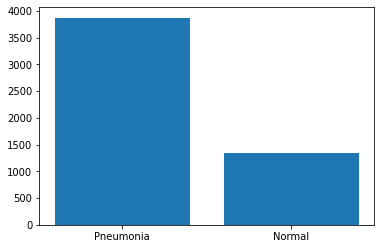

In [4]:
normal_vs_not_normal('train')

val dir size (pneumonia): 8
val dir size (normal): 8


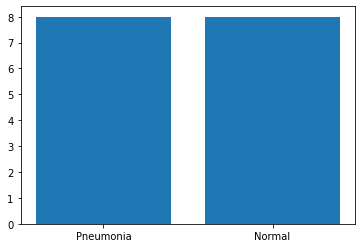

In [5]:
normal_vs_not_normal('val')

test dir size (pneumonia): 390
test dir size (normal): 234


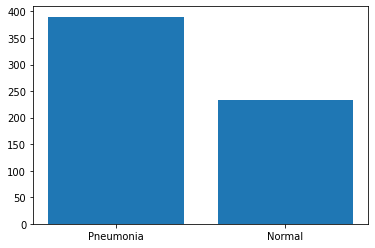

In [6]:
normal_vs_not_normal('test')

As we can see, our data is heavily imbalanced for training and testing sets. If we leave at that, the models will categorize an X-ray image as pneumonia more often than not. 

For that, we can either use weights while calculating loss function or use resampling, specifically oversampling minority class. From running both approaches, the latter showed better results, so I used it in the end.

In [7]:
norm = []
pn = []
norm_len, pn_len = 1341, 3875
for i in range(norm_len):
    norm.append(image_datasets['train'][i])
for i in range(norm_len, norm_len+pn_len):
    pn.append(image_datasets['train'][i])

normal_resampled = resample(norm,
                            replace=True,
                            n_samples=pn_len,
                            random_state=27)

image_datasets['train'] = pn + normal_resampled
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [8]:
def display_images(dir_name, title):
    i = 0
    image_count = 9
    f, axs = plt.subplots(3, 3, figsize=(15,15))
    f.suptitle(title)
    for filename in os.listdir(dir_name):
        if i == image_count: break
        img = plt.imread(os.path.join(dir_name, filename))
        row, col = i // 3, i % 3
        axs[row, col].imshow(img, cmap='gray')
        plt.axis('off')
        i += 1
    plt.show()

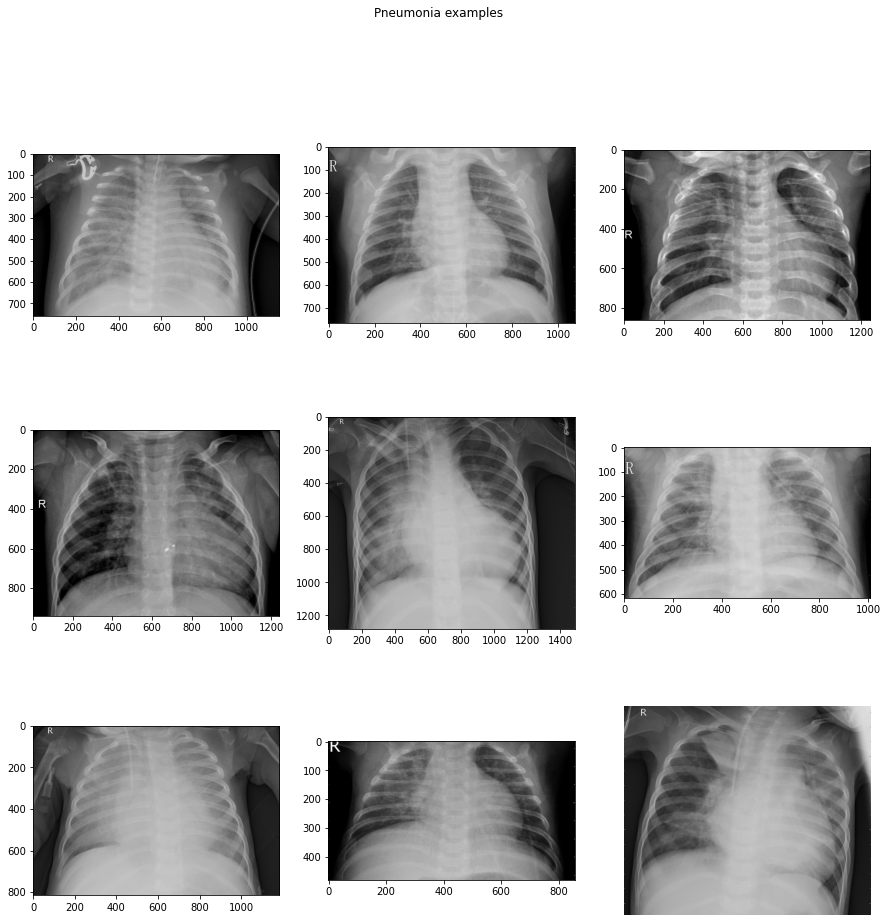

In [9]:
display_images(data_dir + "/train/PNEUMONIA", "Pneumonia examples")

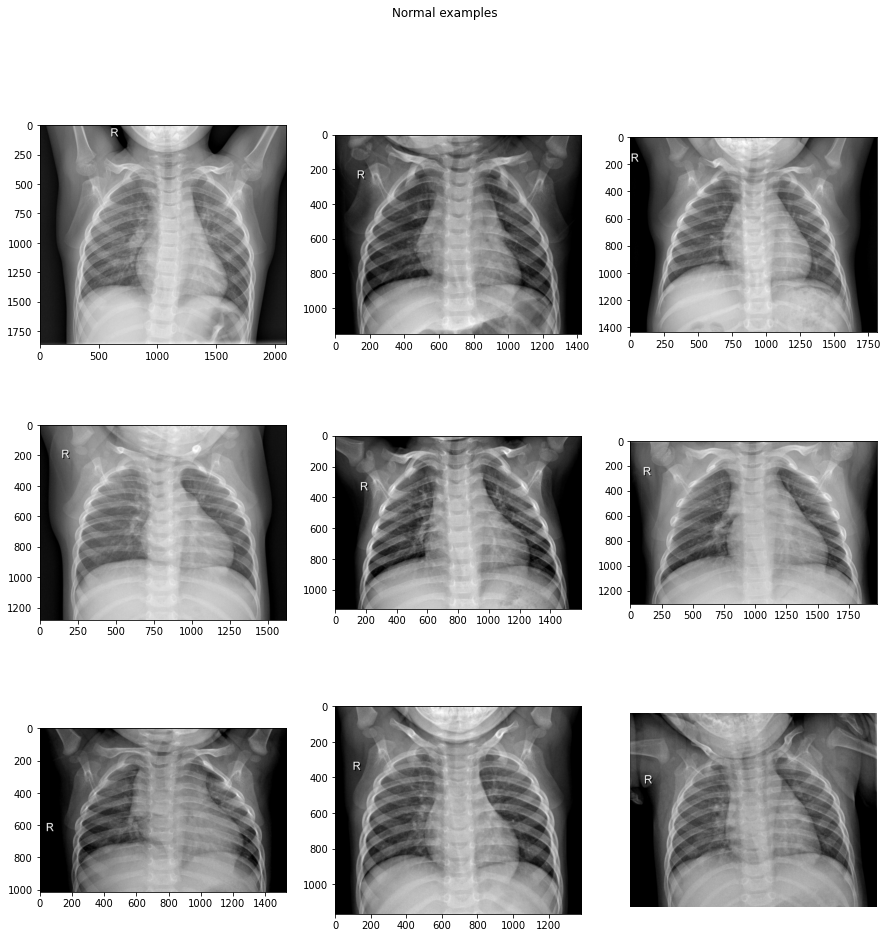

In [10]:
display_images(data_dir + "/train/NORMAL", "Normal examples")

We can use a certain pretrained architecture in order to train it on our data and then compare accuracy, precision and recall across arrchitectures. Also, adding loss curve will help analyze how fast the model learns.

Here is the usual procedure of training.

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    train_accuracy_history = []

    val_loss_history = []
    val_accuracy_history = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

Here are the functions to download each architecture and change the last layer so that each model classifies only two features. We also pass the parameter with weights for loss function since the data is imbalanced.

In [12]:
def resnet50(criterion):
    model_conv = torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)
    model_conv = model_conv.to(device)

    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    model_conv, tr_loss, tr_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=30)
    return model_conv, tr_loss, tr_acc, val_loss, val_acc

In [13]:
def densenet(criterion):
    model_dense = torchvision.models.densenet121(pretrained=True)
    for param in model_dense.parameters():
        param.requires_grad = False

    num_ftrs = model_dense.classifier.in_features
    model_dense.classifier = nn.Linear(num_ftrs, 2)
    model_dense = model_dense.to(device)

    optimizer_dense = optim.SGD(model_dense.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dense, step_size=7, gamma=0.1)

    model_dense, tr_loss, tr_acc, val_loss, val_acc = train_model(model_dense, criterion, optimizer_dense,
                             exp_lr_scheduler, num_epochs=30)
    return model_dense, tr_loss, tr_acc, val_loss, val_acc

In [14]:
def vgg16(criterion):
    model_conv = torchvision.models.vgg16(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ftrs = model_conv.classifier[6].in_features
    model_conv.classifier[6] = nn.Linear(num_ftrs, 2)
    model_conv = model_conv.to(device)

    optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    model_conv, tr_loss, tr_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=30)
    return model_conv, tr_loss, tr_acc, val_loss, val_acc

In a test function apart from accuracy we also calculate the precision and recall to see how many positive identifications were correct and how many actual positives were identified correctly.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

In [15]:
def test_model(model_conv, criterion):
    model_conv.eval()
    phase = 'test'
    running_loss = 0.0
    running_corrects = 0
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        for i in range(len(labels.data)):
            if labels.data[i] == 1:
                if preds[i] == 1: true_pos += 1
                else: false_neg += 1
            else: 
                if preds.data[i] == 1: false_pos += 1

    test_loss = running_loss / dataset_sizes[phase]
    test_acc = running_corrects.double() / dataset_sizes[phase]
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, test_loss, test_acc))
    print('{} Precision: {:.4f}'.format(phase, precision))
    print('{} Recall: {:.4f}'.format(phase, recall))

In [16]:
def plot_loss_acc(loss, acc, phase):
    plt.plot(loss)
    plt.plot(acc)

    plt.title('Learning curves')
    plt.xlabel('Epoch #')
    plt.legend([f'{phase} loss', f'{phase} accuracy']);

The weights for criterion to deal with imbalanced data. As has been mentioned above, this approach yielded worse results than resampling, so that is why it is commented.

In [17]:
# pn_count, norm_count = len(os.listdir(data_dir + '/train/PNEUMONIA')), len(os.listdir(data_dir + '/train/NORMAL'))
# weight_for_pn = pn_count / (pn_count + norm_count)
# weight_for_n = norm_count / (pn_count + norm_count)
# weights = torch.FloatTensor([weight_for_pn, weight_for_n]).to(device)
criterion = nn.CrossEntropyLoss()

Here is the training of ResNet50, DenseNet121 and VGG16 and their corresponding loss and accuracy curves.

In [43]:
model_resnet50, tr_loss, tr_acc, val_loss, val_acc = resnet50(criterion)

Epoch 0/29
----------
train Loss: 0.4411 Acc: 0.8174
val Loss: 0.3632 Acc: 0.7500

Epoch 1/29
----------
train Loss: 0.4203 Acc: 0.8323
val Loss: 0.2986 Acc: 0.8750

Epoch 2/29
----------
train Loss: 0.3999 Acc: 0.8483
val Loss: 1.3266 Acc: 0.6250

Epoch 3/29
----------
train Loss: 0.3992 Acc: 0.8533
val Loss: 0.2839 Acc: 0.8750

Epoch 4/29
----------
train Loss: 0.3733 Acc: 0.8546
val Loss: 0.2629 Acc: 0.9375

Epoch 5/29
----------
train Loss: 0.3825 Acc: 0.8552
val Loss: 0.2069 Acc: 0.9375

Epoch 6/29
----------
train Loss: 0.3498 Acc: 0.8712
val Loss: 0.6402 Acc: 0.6250

Epoch 7/29
----------
train Loss: 0.2763 Acc: 0.8863
val Loss: 0.3271 Acc: 0.7500

Epoch 8/29
----------
train Loss: 0.2701 Acc: 0.8883
val Loss: 0.3223 Acc: 0.8125

Epoch 9/29
----------
train Loss: 0.2586 Acc: 0.8974
val Loss: 0.2364 Acc: 0.9375

Epoch 10/29
----------
train Loss: 0.2436 Acc: 0.9012
val Loss: 0.3522 Acc: 0.7500

Epoch 11/29
----------
train Loss: 0.2522 Acc: 0.8928
val Loss: 0.2463 Acc: 0.8750

Ep

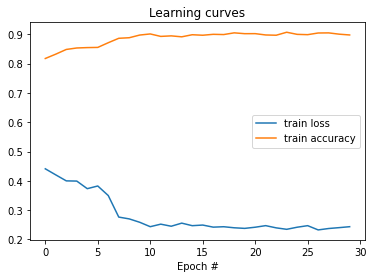

In [44]:
plot_loss_acc(tr_loss, tr_acc, 'train')

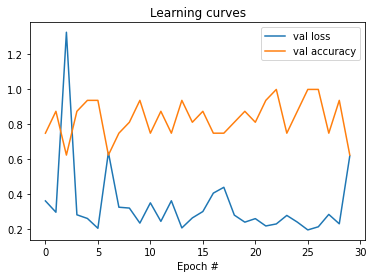

In [45]:
plot_loss_acc(val_loss, val_acc, 'val')

In [46]:
test_model(model_resnet50, criterion)

test Loss: 0.3232 Acc: 0.8814
test Precision: 0.8990
test Recall: 0.9128


In [18]:
model_dense, tr_loss, tr_acc, val_loss, val_acc = densenet(criterion)

Epoch 0/29
----------
train Loss: 0.4349 Acc: 0.8221
val Loss: 0.2443 Acc: 0.8750

Epoch 1/29
----------
train Loss: 0.4797 Acc: 0.8236
val Loss: 0.4235 Acc: 0.8125

Epoch 2/29
----------
train Loss: 0.4411 Acc: 0.8388
val Loss: 0.7164 Acc: 0.7500

Epoch 3/29
----------
train Loss: 0.4177 Acc: 0.8486
val Loss: 0.9187 Acc: 0.7500

Epoch 4/29
----------
train Loss: 0.4171 Acc: 0.8490
val Loss: 0.9945 Acc: 0.7500

Epoch 5/29
----------
train Loss: 0.4198 Acc: 0.8439
val Loss: 0.6627 Acc: 0.7500

Epoch 6/29
----------
train Loss: 0.4136 Acc: 0.8521
val Loss: 0.5834 Acc: 0.7500

Epoch 7/29
----------
train Loss: 0.3121 Acc: 0.8785
val Loss: 0.8327 Acc: 0.7500

Epoch 8/29
----------
train Loss: 0.3041 Acc: 0.8777
val Loss: 0.5871 Acc: 0.7500

Epoch 9/29
----------
train Loss: 0.3067 Acc: 0.8743
val Loss: 0.7726 Acc: 0.7500

Epoch 10/29
----------
train Loss: 0.2921 Acc: 0.8777
val Loss: 0.7342 Acc: 0.7500

Epoch 11/29
----------
train Loss: 0.2820 Acc: 0.8865
val Loss: 0.3566 Acc: 0.6875

Ep

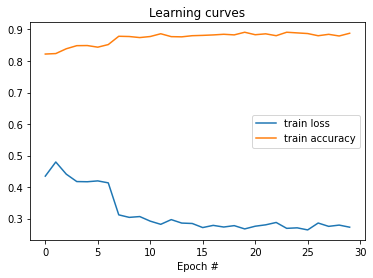

In [19]:
plot_loss_acc(tr_loss, tr_acc, 'train')

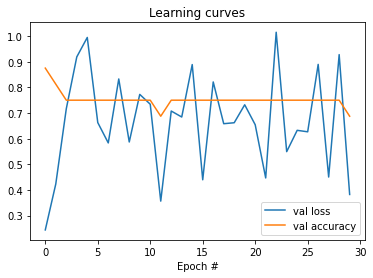

In [20]:
plot_loss_acc(val_loss, val_acc, 'val')

In [21]:
test_model(model_dense, criterion)

test Loss: 0.2722 Acc: 0.8958
test Precision: 0.9114
test Recall: 0.9231


In [18]:
model_vgg16, tr_loss, tr_acc, val_loss, val_acc = vgg16(criterion)

Epoch 0/29
----------
train Loss: 0.4106 Acc: 0.8659
val Loss: 0.3725 Acc: 0.8750

Epoch 1/29
----------
train Loss: 0.3843 Acc: 0.8796
val Loss: 1.1345 Acc: 0.7500

Epoch 2/29
----------
train Loss: 0.4245 Acc: 0.8843
val Loss: 0.3579 Acc: 0.8750

Epoch 3/29
----------
train Loss: 0.3962 Acc: 0.8861
val Loss: 1.0858 Acc: 0.6875

Epoch 4/29
----------
train Loss: 0.3966 Acc: 0.8929
val Loss: 0.4440 Acc: 0.8125

Epoch 5/29
----------
train Loss: 0.3983 Acc: 0.8902
val Loss: 0.2424 Acc: 0.9375

Epoch 6/29
----------
train Loss: 0.4025 Acc: 0.8883
val Loss: 0.9385 Acc: 0.7500

Epoch 7/29
----------
train Loss: 0.3216 Acc: 0.9023
val Loss: 0.5834 Acc: 0.8125

Epoch 8/29
----------
train Loss: 0.3092 Acc: 0.9034
val Loss: 0.5661 Acc: 0.8125

Epoch 9/29
----------
train Loss: 0.2884 Acc: 0.9086
val Loss: 0.7250 Acc: 0.7500

Epoch 10/29
----------
train Loss: 0.2680 Acc: 0.9128
val Loss: 0.3804 Acc: 0.8750

Epoch 11/29
----------
train Loss: 0.2574 Acc: 0.9139
val Loss: 0.3768 Acc: 0.8750

Ep

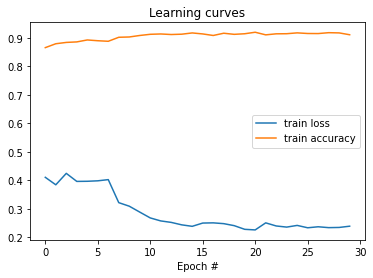

In [19]:
plot_loss_acc(tr_loss, tr_acc, 'train')

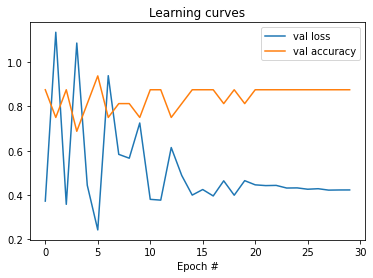

In [20]:
plot_loss_acc(val_loss, val_acc, 'val')

In [21]:
test_model(model_vgg16, criterion)

test Loss: 0.6113 Acc: 0.8478
test Precision: 0.8792
test Recall: 0.8769


### Conclusion

Three models used 30 epochs for training and we can see that starting from epochs 10-12 the results of loss and accuracy start to change less rapidly.

We can see that out of three models VGG16 has the greatest loss and the lowest accuracy, precision and recall, while DenseNet121 and ResNet50 have a similar accuracy of 88-89%, though the former has a better number of precision and recall. Loss is also arounf 0.27, while in ResNet50 it is 0.32.